In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(GenomicFiles)
    library(Cairo)
    library(rtracklayer)
    library(Hmisc)
    library(scales)
});

options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml");
theme_set(theme_classic(base_family = "Lucida Sans"));
mycols = c('forestgreen', '#555555', 'firebrick');
setwd("github");

In [2]:
Size = fasta.seqlengths("./data/K562_AllTREs_110819.fa");

NegCtrls = c( 'HS002', 'HS006', names(Size)[ substr(names(Size), 1, 3) == "ORF"] );
PosCtrls = c( 'HS001', 'HS005', 'CMV584', 'RSV', paste0("MYC_E", 1:7) );
Others = c(
    'HS018', 'PGK',
    names(Size)[substr(names(Size), 1, 2) == 'NC' ]
);
Ctrls = c( NegCtrls, PosCtrls, Others );

In [3]:
# load sequence verified clone info
eSTARR = import.bed("./data/eSTARR_Clones_110819.bed")
names(eSTARR) = eSTARR$name;
eSTARR$name = NULL;

invalidIDs = read_tsv( "./data/InvalidClones_110819.tsv", col_names = T );
invalidIDs = invalidIDs$ID[!invalidIDs$isValid];
eSTARR = eSTARR[!names(eSTARR) %in% invalidIDs];
length(eSTARR);

Parsed with column specification:
cols(
  ID = col_character(),
  isValid = col_logical()
)


[1] 959

In [4]:
Summary = read.csv("./data/K562_eSTARR_voom.csv", header=T);
Summary$ID = as.character(Summary$ID);
rownames(Summary) = Summary$ID;
Summary = Summary[rownames(Summary) %in% names(eSTARR),];
ids = Summary$ID;
hasDel = ids %in% substr(ids, 1, nchar(ids)-1) & substr(ids, 1, 1) == "K";
isB = substr(ids, nchar(ids), nchar(ids)) == "B" & substr(ids, 1, 1) == "K";
isC = substr(ids, nchar(ids), nchar(ids)) == "C" & substr(ids, 1, 1) == "K";
Summary[isB|isC,"ID"] = substr(ids[isB|isC], 1, nchar(ids)-1);

Summary = Summary %>% mutate(logFC=NULL, CW=logFC.CW, logFC.CCW=NULL, logFC.CW=NULL, p.CCW=NULL, p.CW=NULL);
extdat = left_join( Summary[hasDel,], Summary[isB,], by="ID" );
extdat = left_join( extdat, Summary[isC,], by="ID" );
colnames(extdat) = c( colnames(Summary), paste0("B.", colnames(Summary)[-2]), paste0("C.", colnames(Summary)[-2]) );
extdat = extdat %>% filter(!is.na(B.CW) | !is.na(C.CW));
extdat$class = factor(substr(extdat$ID, 2, 3));
extdat = extdat %>% arrange(call);

head(extdat);

ID,call,Size,CW,B.ID,B.Size,B.CW,C.ID,C.Size,C.CW,class
<chr>,<fct>,<int>,<dbl>,<fct>,<int>,<dbl>,<fct>,<int>,<dbl>,<fct>
KSUUT0021,Enhancer,382,3.213002,NA,NA,NA,NA,293,2.8416366,SU
KUUUT0043,Enhancer,299,3.918701,NA,NA,NA,NA,205,2.4071521,UU
KUUAE0071,Enhancer,270,3.341104,NA,NA,NA,NA,181,1.9716304,UU
KSUUT0008,Enhancer,292,3.238109,NA,197,2.5951082,NA,NA,NA,SU
KUUUT0021,Enhancer,280,3.159169,Inactive,185,0.8124788,Inactive,191,-0.1677236,UU
KSUUT0136,Enhancer,360,3.152845,NA,265,2.4564421,NA,NA,NA,SU


In [5]:
lm_eqn2 = function(x, y) {
    ct = cor.test(x, y);
    eq = substitute(italic(r)~"="~rval~" "~italic(p)==pv,
        list(pv = format(ct$p.value, digits = 2),
             rval = format(unname(ct$estimate), digits = 2)));
    return(as.character(as.expression(eq)));
}

Warning message:
“Removed 8 rows containing missing values (geom_path).”Warning message:
“Removed 9 rows containing missing values (geom_point).”

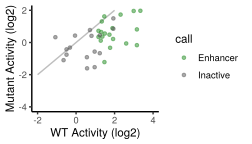

In [6]:
alldat = rbind(
    data.frame( x=extdat$CW, y=extdat$B.CW, call=extdat$call ),
    data.frame( x=extdat$CW, y=extdat$C.CW, call=extdat$call )
);
alldat = alldat[!is.na(alldat$y),];

options(repr.plot.width=3.5, repr.plot.height=2)
print(
    ggplot(alldat, aes(x, y, col=call)) +
    xlab("WT Activity (log2)") + ylab("Mutant Activity (log2)") +
    xlim(-2, 4) + ylim(-4, 2) +
    geom_line( data=data.frame(), aes( x=-6:6, y=-6:6 ), col="gray") +
    geom_point(alpha=0.5, size=0.9) +
    scale_color_manual(values=mycols)
);

Warning message:
“Removed 3 rows containing missing values (geom_point).”

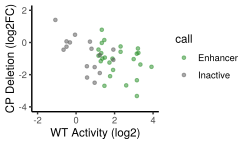

In [7]:
alldat$mutFC = alldat$y-alldat$x;

print(
    ggplot(alldat, aes(x, mutFC, col=call)) +
    xlab("WT Activity (log2)") + ylab("CP Deletion (log2FC)") +
    xlim(-2, 4) + ylim(-4, 2) +
    geom_point(alpha=0.5, size=0.9) +
    scale_color_manual(values=mycols)
);

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”


	Welch Two Sample t-test

data:  y by Genotype
t = 4.0213, df = 46.046, p-value = 0.000213
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.5521073 1.6587576
sample estimates:
   mean in group WT mean in group CPdel 
           2.164457            1.059024 


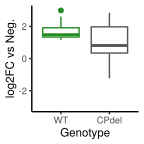

In [8]:
options(repr.plot.width=2, repr.plot.height=2)
enhdat = rbind(
    data.frame( Genotype="WT",    y=alldat$x[alldat$call == "Enhancer"] ),
    data.frame( Genotype="CPdel", y=alldat$y[alldat$call == "Enhancer"] )
    );
print(
    ggplot(enhdat, aes(factor(Genotype), as.numeric(y), col=Genotype)) +
    xlab("Genotype") + ylab("log2FC vs Neg.") +
    geom_boxplot(show.legend = F) + ylim(-3, 3) +
    scale_color_manual(values=mycols)
);
t.test( y ~ Genotype, data=enhdat );

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”

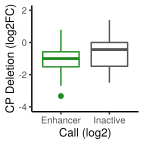

In [9]:
print(
    ggplot(alldat, aes(factor(call), mutFC, col=call)) +
    xlab("Call (log2)") + ylab("CP Deletion (log2FC)") +
    geom_boxplot(show.legend = F) + ylim(-4, 2) +
    scale_color_manual(values=mycols)
);